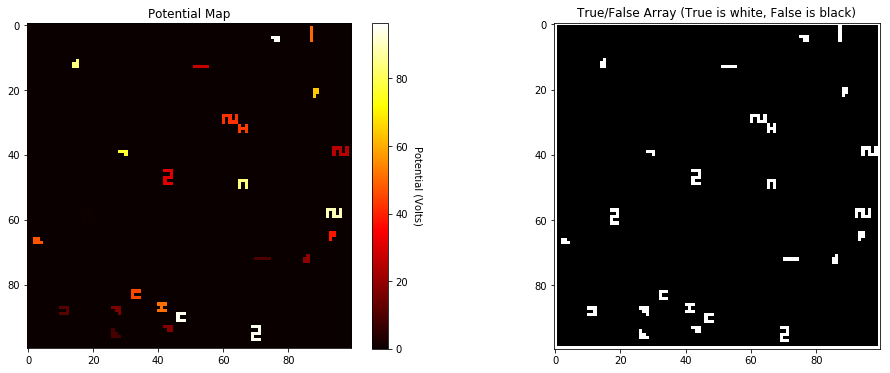

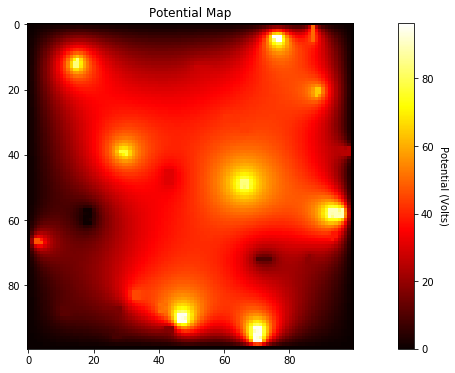

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.fftpack import dst, idst
from matplotlib.animation import FuncAnimation
import random as rand
import IPython.display as display


def cArys(x,y):
    V=np.zeros((x,y))
    TF=np.ones((x,y),dtype=bool)
    Fy=np.zeros((1,y),dtype=bool)
    Fx=np.zeros((1,x),dtype=bool)
    TF[0]=TF[x-1]=Fy
    TF.T[0]=TF.T[y-1]=Fx
    return V,TF

def smArys(ind,rot,pot):
    if ind==0:
        A=[[pot,pot,0],[pot,pot,pot]]
        return rota(np.array(A),rot)
    if ind==1:
        A=[[pot,pot,pot,pot,pot]]
        return rota(np.array(A),rot)
    if ind==2:
        A=[[pot,pot,pot],[0,0,pot],[pot,pot,pot]]
        return rota(np.array(A),rot)
    if ind==3:
        A=[[pot,pot,pot,0,pot],[pot,0,pot,0,pot],[pot,0,pot,pot,pot]]
        return rota(np.array(A),rot)
    if ind==4:
        A=[[pot,pot,pot],[0,pot,pot],[0,0,pot]]
        return rota(np.array(A),rot)
    if ind==5:
        A=[[pot,0,pot],[pot,pot,pot],[pot,0,pot]]
        return rota(np.array(A),rot)
    if ind==6:
        A=[[0,pot],[0,pot],[pot,pot]]
        return rota(np.array(A),rot)
    return False
    
def rota(A,rot):
    for n in range(0,rot):
        A=np.rot90(A)
    return A

def insrt(xi,yi,A,V,TF):
    lx,ly=np.shape(A)
    if np.all(TF[xi:xi+lx,yi:yi+ly]==True):
        V[xi:xi+lx,yi:yi+ly]=A
        TF[xi:xi+lx,yi:yi+ly]=(A==0)
        return False
    else:
        return True
        
def genInit(x,y,nSmall,maxPot):
    V,TF=cArys(x,y)
    for n in range(nSmall):
        check=True
        while check:
            ind=rand.randint(0,6)
            rot=rand.randint(0,3)
            pot=rand.uniform(0,maxPot)
            A=smArys(ind,rot,pot)
            xi=rand.randint(0,x-1)
            yi=rand.randint(0,y-1)
            check=insrt(xi,yi,A,V,TF)
    TF=np.logical_not(TF)
    return V,TF

##########################################################################################################

V,TF=genInit(100,100,25,100)
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("Potential Map")
plt.imshow(V,cmap="hot")
cbar=plt.colorbar()
cbar.set_label("Potential (Volts)", rotation=270,labelpad=15)
plt.subplot(122)
plt.title("True/False Array (True is white, False is black)")
plt.imshow(TF,cmap="gray");
##########################################################################################################

V_plot=V.copy()
dif= 1
tol= 10**-12
while dif >= tol:
    V_plot_last = V_plot.copy()
    left = np.roll(V_plot, 1, axis=1)
    right = np.roll(V_plot, -1, axis=1)
    above = np.roll(V_plot, -1, axis=0)
    below = np.roll(V_plot, 1, axis=0)
    V_plot[1:-1, 1:-1] = 0.25*(left[1:-1, 1:-1] + right[1:-1, 1:-1] +above[1:-1, 1:-1] + below[1:-1, 1:-1])
    
    np.add(V_plot, -V_plot, out=V_plot, where =TF)
    np.add(V_plot, V, out=V_plot, where =TF)
    dif = np.max(abs(V_plot_last-V_plot))
    
plt.figure(figsize=(16,6))
plt.title("Potential Map")
plt.imshow(V_plot,cmap="hot")
cbar=plt.colorbar()
cbar.set_label("Potential (Volts)", rotation=270,labelpad=15)


q = 1
m = 1
x0, y0, vx0, vy0 = 50,50,0,0
Ex, Ey = np.gradient(V_plot)
ax, ay = -q*Ex/m, -q*Ey/m
pc=[m,q,x0,y0,vx0,vy0]
    
def Motion(pc, dt):
    vx = pc[4] + ax[int(np.floor(pc[2])), int(np.floor(pc[3]))]*dt
    vy = pc[5] + ay[int(np.floor(pc[2])), int(np.floor(pc[3]))]*dt
    x = 0.5*ax[int(np.floor(pc[2])), int(np.floor(pc[3]))]*dt**2 + vx*dt + pc[2]
    y = 0.5*ay[int(np.floor(pc[2])), int(np.floor(pc[3]))]*dt**2 + vy*dt + pc[3]
    x_L, y_L = np.shape(V_plot)
    if x < 0:
        x = -x
    if x > x_L:
        x = 2*x_L - x
    if y < 0:
        y = -y
    if y > y_L:
        y = 2*y_L - y
        
    pc[2:] = [x,y,vx,vy]
    

In [66]:
q = 1
m = 1
x0, y0, vx0, vy0 = 50,50,-5,-5
Ex, Ey = np.gradient(V_plot)
ax, ay = -q*Ex/m, -q*Ey/m
pc=[m,q,x0,y0,vx0,vy0]

fig = plt.figure()
anr, = plt.plot([], "o", markersize=5, color="g")
plt.imshow(V_plot, cmap="pink")
trajectory = []
for t in range(500):
    if t%5 == 0:
        trajectory.append(pc.copy())
    Motion(pc, .1)    
def animate(frame):
    
    anr.set_data(trajectory[frame][2], trajectory[frame][3])
anim = FuncAnimation(fig, animate, frames=100, interval=50)
video = anim.to_html5_video()
plt.close()
display.HTML(video)